Using integrals as a metric of contextual effects seem straightforward. Previous analysis has shown that both integral
and significant integral are closely correlated, so there is a value on using the later since its more robust to noise.
This approach has the shortcoming of not giving information about the temporal evolution of the contextual effects.
These are potential goals of this notebook:
1. Center of mass calculation
    1. for all bins? for significant bins!
2. Examples of cells from parameter space
3. train classifier + cross validation (optional, should go in another notebook?)
4. total integral/center-of-mass threshold (clean up memory less units)
    1.compare dPCA between full population vs filtered (context units)
5. classify probes by wave source (eg. ferret vocalizations)
6. baseline evoked activity threshold
    1. specific for context probe related activity (already in place?)
    2. in a probe specific manner
7. clean up probe quality
    1. treat different unit-probe combination as individual cells (collapse/mean across bigger population)
    2. filter out non responsive unit-probe combinations
8. Check spectrogram for responding units
    1. check and compare vs silence (silence as probe?)

In [1]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

import src.visualization.fancy_plots as fplt
from src.data.cache import set_name

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-12-23 135115.log


In [2]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)

## Proff of concept

Tests how to calculate the center of mass of any arbitrary vector.
The same equation is used in "cpn_batch_summary_metrics.py"

0.8255413950371603


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


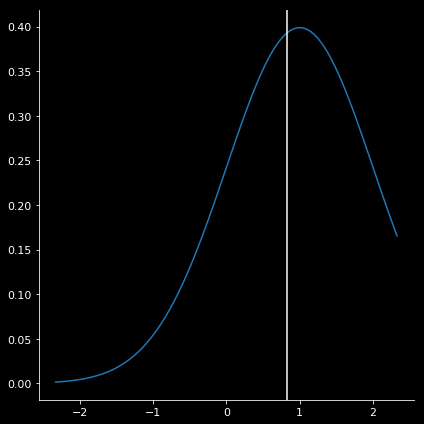

In [3]:
#toy example on how to calculate the center of mass.
def center_of_mass(values, times):
    return np.sum(values * times) / np.sum(values)

# generate some arbitrary data
x = np.linspace(sst.norm.ppf(0.01),
                sst.norm.ppf(0.99), 100)
y = sst.norm.pdf(x, 1, 1)

# calculates the center of mas
mass = center_of_mass(y, x)
print(mass)

# plots example
fig, ax = plt.subplots()
ax.plot(x, y)
ax.axvline(mass)
plt.show(fig)

In [4]:
# loads the summary metrics
config = ConfigParser()
config.read_file(open(pl.Path().cwd().parent / 'config' / 'settings.ini'))

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': ['silence', 'continuous', 'similar', 'sharp'],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'DF_summary' / set_name(meta)

DF = jl.load(summary_DF_file)


# create the id_probe pair for

DF['id_probe'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id_probe', 'probe']].agg('_'.join, axis=1)

## Application to data

# Single cell analysis

Now plots the distribution of cells in the new parameter space, of particular interest is to compare how the old
parametric values (tau, r0) are related to the new non parametric values (center-of-mass and integral)

1. fisrt lets see howe the center of mass and its significant variant behave


In [5]:
# defines a general function to plot scatters of parameter space for the mean of probe and context_pair

def parameter_space_scatter(x, y, analysis='SC', source='dprime', ax=None, show=True, use_id_probe=False):

    # x = 'significant_abs_sum'
    # y = 'significant_abs_mass_center'
    # analysis = 'dPCA'
    # source = 'dprime'
    # show=True
    # ax=None

    ff_parameter = DF.parameter.isin([x, y])
    ff_analysis = DF.analysis == analysis
    ff_source = DF.source == source
    if use_id_probe is True:
        ff_probe = DF.probe != 'mean'
    elif use_id_probe is False:
        ff_probe = DF.probe == 'mean'
    else:
        raise ValueError('use_id_probe must be boolean')
    ff_transpair= DF.transition_pair == 'mean'
    ff_good = np.logical_or(DF.goodness > 0.1, DF.goodness.isna()) # empirical good value to filter out garbage cells


    filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good, :]
    pivoted = filtered.pivot_table(index=['id_probe', 'region', 'siteid'],
                                   columns='parameter', values='value').dropna().reset_index()

    ax = sns.regplot(x=x, y=y, data=pivoted, ax=ax, color='white')
    ax.axhline(0, linestyle='--')
    ax.axvline(0, linestyle='--')

    title = f'{analysis} summary {x} vs {y} {len(pivoted.index)}units'
    ax.set_title(fill(title, 35))
    fig = ax.get_figure()

    if show: plt.show(fig)
    return fig, ax

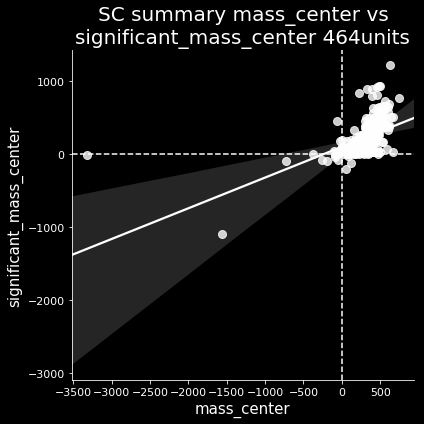

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a12e486a0>)

In [6]:
x = 'mass_center'
y = 'significant_mass_center'
parameter_space_scatter(x, y)

Clearly there is an issue with the center of mas calculation, which should never take negative values since its  units
are time in seconds after the onset of the probe sound. Since times can never get negatives values then the negative mass
center must come from a "negative mass" i.e negative d primes. then I need to use the absolute dprime values as I have
already done before for the integral


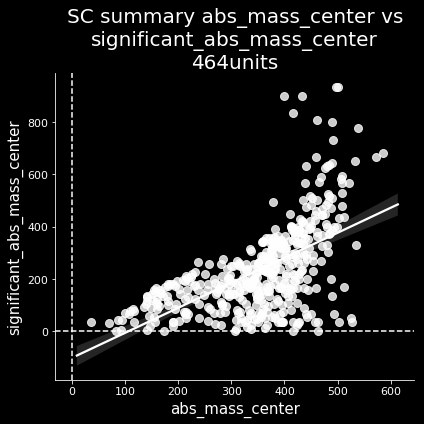

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a11084cf8>)

In [7]:
x = 'abs_mass_center'
y = 'significant_abs_mass_center'
parameter_space_scatter(x, y)

This deffinitely looks much better, but I dont trust the cells withe super high centers of mass regardless of
significance. Most likely these are cells with some random blips of significant contextual effects later on, but
significance does not mean a big effect size,
2. to check effect size amplitude, plot duration (center of mass) vs amplitude (integral)

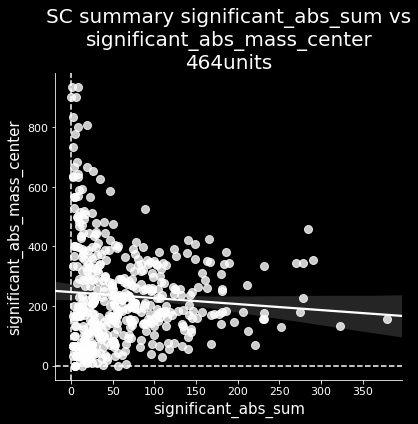

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a10fe54a8>)

In [8]:
x = 'significant_abs_sum'
y = 'significant_abs_mass_center'

parameter_space_scatter(x, y)

Now lets compare it with the old parameter space R0 Tau (both for the d-rpime value)

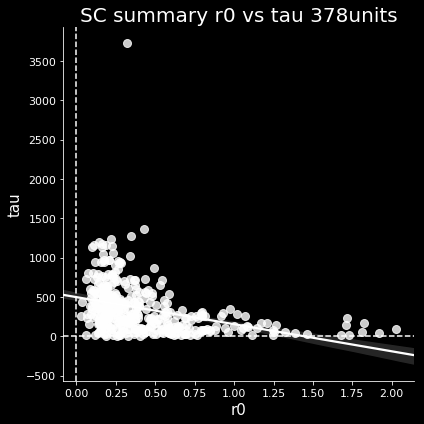

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a107d7be0>)

In [9]:
x = 'r0'
y = 'tau'
parameter_space_scatter(x, y)

Finally, while there is a resemblance between the old parameter space and the new "non-parameter" space, we need to
compare directly the equivalents: Tau and center of mass; Integral and R0.

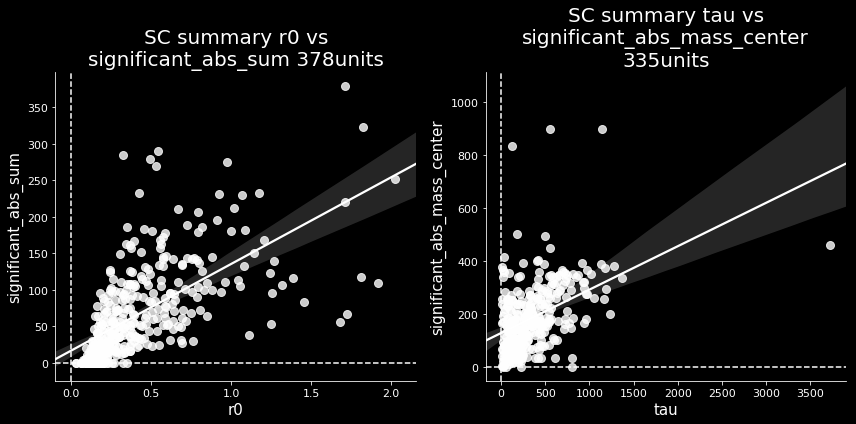

In [10]:
# make the comparisons in subplots
fig, axes = plt.subplots(1,2,squeeze=True)

x = 'r0'
y = 'significant_abs_sum'
_ = parameter_space_scatter(x,y, ax=axes[0], show=False)

# duration comparison
x = 'tau'
y = 'significant_abs_mass_center'
fig, ax = parameter_space_scatter(x,y, ax=axes[1], show=False)

fig.set_size_inches(12,6)
plt.show(fig)

We can question how adequate are the values of significant_absolute sum and mass center given that they have of multiple
comparisons. In particular imagine that a cell has a relatively big but non-significant contextual effect under probe 2,
and a small but significant contextual effect to probe 5. How thing are set up, if take the mean across probes, the non
significant effect will be averaged into what is called a significant mean effect.

to check whether this is the case, and it is inconvenient, it is worthwhile comparing the new non-parameters to the r0 and
tau of the significance profile. I hope they are somewhat correlated

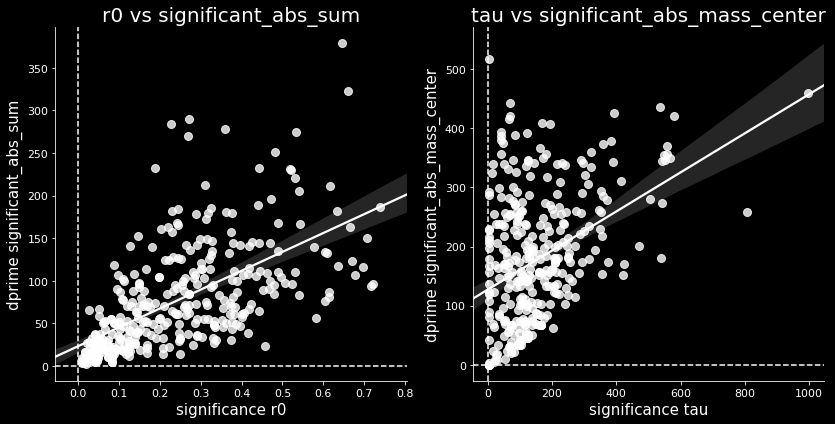

In [11]:
# make the comparisons in subplots
fig, axes = plt.subplots(1,2,squeeze=True)

# defines common filters
good_thresh = 0.1

ff_analysis = DF.analysis == 'SC'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'
ff_good = np.logical_or(DF.goodness > good_thresh, DF.goodness.isnull())

# fits to significance
ff_parameter = DF.parameter.isin(['tau', 'r0'])
ff_source = DF.source == 'significance'
signif_fits = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]

# non-parameter to dprime
ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_source = DF.source == 'dprime'
dprime_non_params = DF.loc[ff_parameter & ff_analysis & ff_probe & ff_transpair & ff_source & ff_good, :]

wdf = pd.concat([signif_fits, dprime_non_params])

# amplitude comparison
x = 'r0'
y = 'significant_abs_sum'
ff_parameter = wdf.parameter.isin([x, y])

filtered = wdf.loc[ff_parameter, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted, color='white', ax=axes[0])
ax.set_xlabel(f'significance {x}')
ax.set_ylabel(f'dprime {y}')

subtitle = f'{x} vs {y}'
ax.set_title(fill(subtitle, 35))

# duration comparison
x = 'tau'
y = 'significant_abs_mass_center'

ff_parameter = wdf.parameter.isin([x, y])

filtered = wdf.loc[ff_parameter, :]
pivoted = filtered.pivot_table(index=['region', 'siteid', 'cellid'],
                               columns='parameter', values='value').dropna().reset_index()

ax = sns.regplot(x=x, y=y, data=pivoted, color='white', ax=axes[1])
ax.set_xlabel(f'significance {x}')
ax.set_ylabel(f'dprime {y}')

subtitle = f'{x} vs {y}'
ax.set_title(fill(subtitle, 35))


for ax in axes:
    ax.axhline(0, linestyle='--')
    ax.axvline(0, linestyle='--')
fig.set_size_inches(12,6)
plt.show(fig)

**in conconclussion:**
1. the non parametric approach (new) recapitulates the parametric one (old).
2. taking the mean over dprimes and calling it significant based on the mean of the significances, while fishi (still
needs multiple comparisons correction) seems to be fine for now

The choice of which one to use lies on the "better explanation power" and less asumptions of the nonparametric approach. it is
interesting that the significan absolute mass center seems to have a limit around 400 ms (regardless of the tau value).

## treatment comparisons
Now lets see how the two new parameters change as a function of context pair and probe

In [12]:
def condition_effect_on_parameter(parameter='significant_abs_mass_center',compare='transition_pair',
                                  analysis='SC', source='dprime',
                                  nan2zero=False,nozero=True,use_id_probe=False):
    if nan2zero:
        cleaned = DF.fillna(value={'value':0})
    elif nan2zero is False:
        cleaned = DF.dropna(axis=0, subset=['value'])
    else:
        raise ValueError('nan2zero not bool')

    if compare == 'probe':
        ff_probe = cleaned.probe != 'mean'
        ff_trans = cleaned.transition_pair == 'mean'
        if use_id_probe is True:
            raise ValueError('cannot use id probes when comparing between probes')
    elif compare == 'transition_pair':
        if use_id_probe is True:
            ff_probe = cleaned.probe != 'mean'
            ff_trans = cleaned.transition_pair != 'mean'

        elif use_id_probe is False:
            ff_probe = cleaned.probe == 'mean'
            ff_trans = cleaned.transition_pair != 'mean'
        else:
            raise ValueError('use_id_probe must be bool')
    else:
        raise ValueError(f'unknown value compare: {compare}')

    if analysis == 'SC':
        index = 'cellid'
    elif analysis in ('dPCA', 'LDA'):
        index = 'siteid'
    else:
        raise ValueError(f'unknown analysis value:{analysis}')

    if use_id_probe is True:
        index = 'id_probe'


    ff_analisis = cleaned.analysis == analysis
    ff_parameter = cleaned.parameter == parameter
    ff_source = cleaned.source == source


    if nozero:
        ff_value = cleaned.value > 0
    elif nozero is False:
        ff_value = cleaned.value >= 0
    else:
        raise ValueError('nozero not bool')

    filtered = cleaned.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_value,
                      [index, compare, 'value']]

    pivoted = filtered.pivot(index=index, columns=compare, values='value')
    pivoted = pivoted[(pivoted.T != 0).any()] #remove rows with only zeros
    pivoted = pivoted.reset_index().dropna()

    molten = pivoted.melt(id_vars=index)

    fig, ax = plt.subplots()
    # _ = fplt.paired_comparisons(ax, data=molten,x=compare, y='value', color='gray', alpha=0.3)
    ax = sns.boxplot(x=compare, y='value', data=molten, ax=ax, color='white', width=0.5)

    # no significant comparisons
    box_pairs = list(itt.combinations(filtered[compare].unique(), 2))
    stat_resutls = fplt.add_stat_annotation(ax, data=molten, x=compare, y='value', test='Wilcoxon',
                                       box_pairs=box_pairs, width=0.5, comparisons_correction='bonferroni')

    if parameter == 'significant_abs_sum':
        ylabel = 'context integral (ms * dprime)'
    elif parameter == 'significant_abs_mass_center':
        ylabel = 'center of mass (ms)'
    else:
        ylabel = 'value'
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    fig = ax.figure
    title = f'{analysis} {source}-{parameter} between {compare} {len(pivoted.index)}units'
    ax.set_title(fill(title, 35))
    plt.show(fig)
    return fig, ax

### probe mean

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

silence_sharp v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.978e-03 stat=6.262e+03
continuous_similar v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.620e-04 stat=5.793e+03
continuous_sharp v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.310e-04 stat=5.690e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

continuous_similar v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.154e-14 stat=4.521e+03
continuous_sharp v.s. continuous_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.829e-09 stat=5.836e+03
silence_similar v.s.

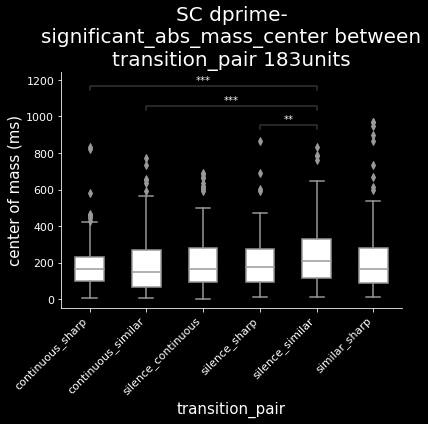

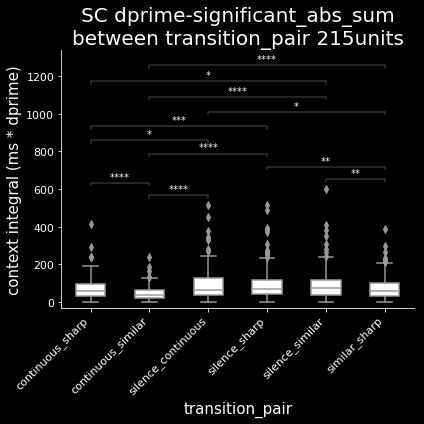

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0dbd94a8>)

In [13]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='SC',
                             nan2zero=False,nozero=True)

condition_effect_on_parameter(parameter='significant_abs_sum', compare='transition_pair', analysis='SC',
                             nan2zero=False,nozero=True)


as seen from above the context pair are related to different amounts of contextual effects, seen both in the integral
and center of mass. The trend shows reduced differences for the continuous and similar pair, and this effect is more
evident for the center of mass than for the integral.

I might be worthwhile normalizing these values to compare betweeen the two...

## calculate over cell-probe combination

If we consider the contextual effects seen for probes presented to the same cell as if they were different cells we can
increase the amount of data.

### single cell id_probe
note how these plots only have 75 valid units in comparison to the mean_probe with 141 units. we are acchivieng a more
reliable signal and metrics by taking the probe mean in this case, and then we reject less zero values

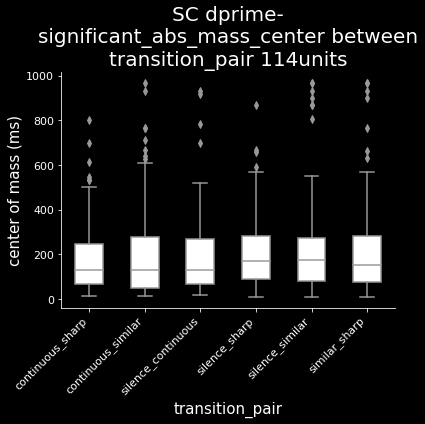

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

continuous_similar v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=8.136e-09 stat=4.135e+03
continuous_sharp v.s. continuous_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.162e-04 stat=5.585e+03
silence_similar v.s. similar_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.419e-02 stat=6.372e+03
silence_sharp v.s. similar_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.462e-02 stat=6.304e+03
continuous_similar v.s. silence_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.766e-12 stat=3.438e+03
continuous_sharp v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.995e-02 stat=6.446e+03
continuous_sharp v.s. silence_sharp: Wilcoxon test (paired 

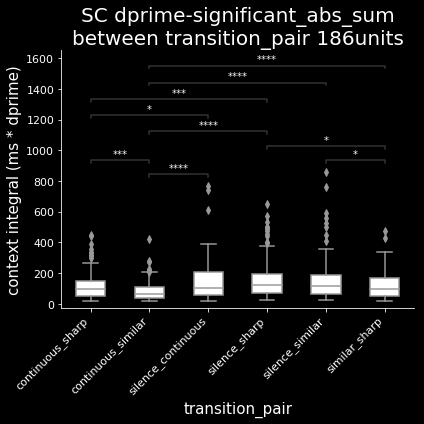

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0db0e2b0>)

In [14]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='SC',
                             nan2zero=False,nozero=True, use_id_probe=True)

condition_effect_on_parameter(parameter='significant_abs_sum', compare='transition_pair', analysis='SC',
                             nan2zero=False,nozero=True, use_id_probe=True)


#todo check following MD cell.

It is noteworthy and worrysome that there is plenty of cell-probe combinations with missing values for some of the
context pairs, even prior to filtering. These values should be filled out as nan during the DF creation, an example to
check and to debug is **AMT028b-01-2 probe_5** where there is only **significant_abs_mass_center** values for
**continuous_sharp: 412** and **silence_continuous: 766**. I bet it is because of small blips at later time points, on
really shitty recordings, but I should check non the less.

### Probe effect
Since there is no systematic selection of probes, the categories are arbitrary and mix of sounds. Any significant effect
here is happening by random chance...

An alternative is to quantify the overall variance between probes for each cell.

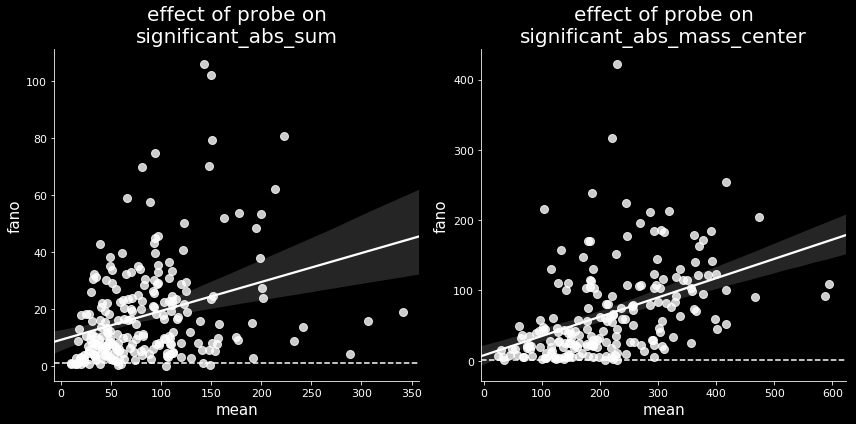

In [15]:
fig, axes = plt.subplots(1,2, squeeze=True)

# common filters
good_thresh = 0.1

ff_probe = DF.probe != 'mean'
ff_trans = DF.transition_pair == 'mean'
ff_source = DF.source == 'dprime'
ff_good = np.logical_or(DF.goodness > good_thresh, DF.goodness.isnull())
ff_value = DF.value > 0
ff_analisis = DF.analysis == 'SC'

# integral
parameter = 'significant_abs_sum'
ff_parameter = DF.parameter == parameter

filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_good & ff_value,
                  ['cellid', 'probe', 'goodness', 'value']]
pivoted = filtered.pivot_table(index=['cellid'], columns='probe', values='value').dropna().reset_index()
pivoted['mean'] = pivoted.mean(axis=1)
pivoted['var'] = pivoted.var(axis=1)
pivoted['fano'] = pivoted['var']/pivoted['mean']
ax = sns.regplot(x='mean', y='fano', data=pivoted, color='white', ax= axes[0])
ax.set_title(fill(f'effect of probe on {parameter}', 35))

# center of mass
parameter = 'significant_abs_mass_center'
ff_parameter = DF.parameter == parameter

filtered = DF.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_good & ff_value,
                  ['cellid', 'probe', 'goodness', 'value']]
pivoted = filtered.pivot_table(index=['cellid'], columns='probe', values='value').dropna().reset_index()
pivoted['mean'] = pivoted.mean(axis=1)
pivoted['var'] = pivoted.var(axis=1)
pivoted['fano'] = pivoted['var']/pivoted['mean']
ax = sns.regplot(x='mean', y='fano', data=pivoted, color='white', ax= axes[1])
ax.set_title(fill(f'effect of probe on {parameter}', 35))

for ax in axes:
    ax.axhline(1, linestyle='--')

fig.set_size_inches(12,6)

plt.show(fig)

interestingly there is a liner increase of std with the mean. Indeed the fano factor seems to be >1 for most cells and
further increasing with the mean. This over-dispersion can be interpreted as clumpiness in the context effects withing
probe space i.e context effects are highly dependent on probes, e.g. for a given cell, contextual effects will be big for
one sound but small for a different sound

# Population analysis

it goes without saying. the same distribution in parameter space, and effect of context_pairs on the parameters
## 1. parameter space

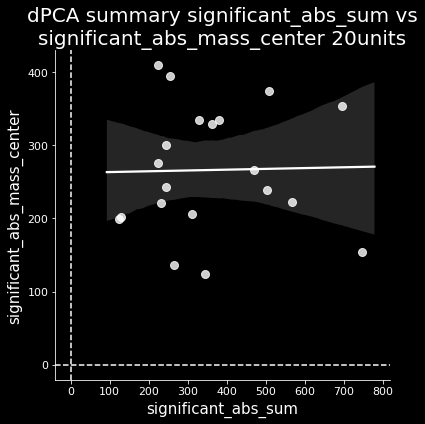

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0da16d30>)

In [16]:
x = 'significant_abs_sum'
y = 'significant_abs_mass_center'
parameter_space_scatter(x, y, analysis='dPCA', )

## 2. effect of transition-pair of parameters by site
here we se how both population analysis recapitulate what we have seen with single cell i.e

### dPCA

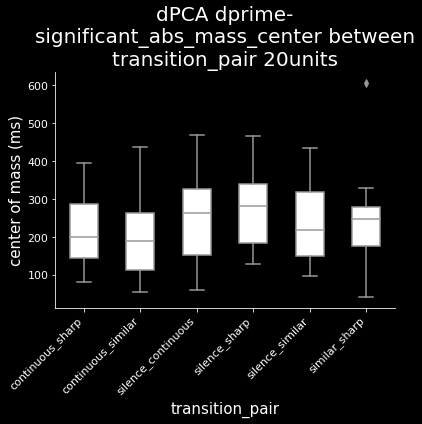

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

continuous_similar v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.812e-04 stat=7.000e+00
continuous_sharp v.s. continuous_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.049e-03 stat=1.400e+01
continuous_similar v.s. silence_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=8.392e-04 stat=1.300e+01
continuous_similar v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.049e-03 stat=1.400e+01
continuous_similar v.s. similar_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.928e-03 stat=2.600e+01


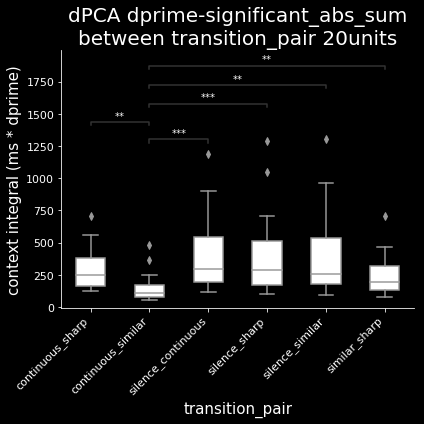

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0d7c1dd8>)

In [17]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='dPCA',
                             nan2zero=False,nozero=True)

condition_effect_on_parameter(parameter='significant_abs_sum', compare='transition_pair', analysis='dPCA',
                             nan2zero=False,nozero=True)

### LDA

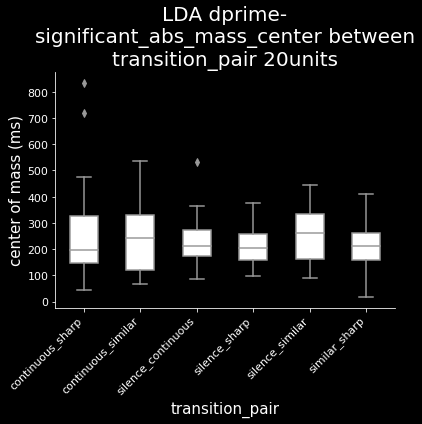

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

continuous_similar v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.144e-05 stat=0.000e+00
continuous_sharp v.s. continuous_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.513e-03 stat=1.900e+01
continuous_similar v.s. silence_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.144e-05 stat=0.000e+00
silence_sharp v.s. similar_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.256e-03 stat=2.300e+01
continuous_similar v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.722e-05 stat=3.000e+00
continuous_similar v.s. similar_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.627e-02 stat=2.800e+01


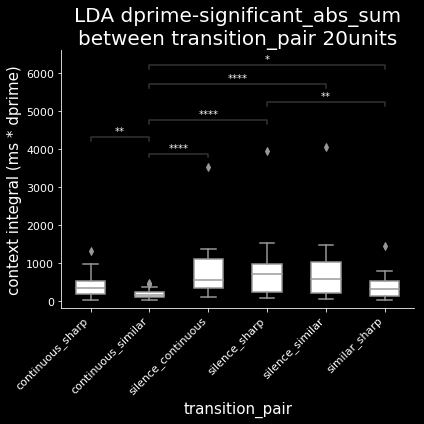

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0d4c57f0>)

In [18]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='LDA',
                             nan2zero=False,nozero=True)

condition_effect_on_parameter(parameter='significant_abs_sum', compare='transition_pair', analysis='LDA',
                             nan2zero=False,nozero=True)



## 3. effect of transition-pair of parameters by site-probe


### dPCA id_probe

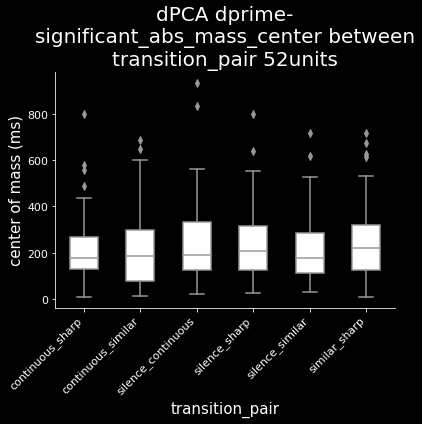

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

continuous_similar v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.272e-06 stat=2.130e+02
continuous_sharp v.s. continuous_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.261e-04 stat=3.480e+02
continuous_similar v.s. silence_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.375e-05 stat=2.870e+02
continuous_similar v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.143e-06 stat=2.120e+02
continuous_similar v.s. similar_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.625e-04 stat=3.430e+02


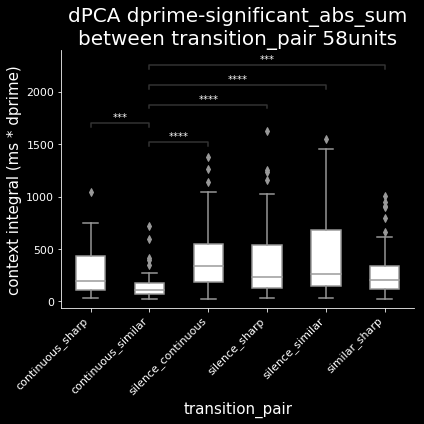

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a10656128>)

In [19]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='dPCA',
                             nan2zero=False,nozero=True, use_id_probe=True)

condition_effect_on_parameter(parameter='significant_abs_sum', compare='transition_pair', analysis='dPCA',
                             nan2zero=False,nozero=True, use_id_probe=True)

### LDA id_probe

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


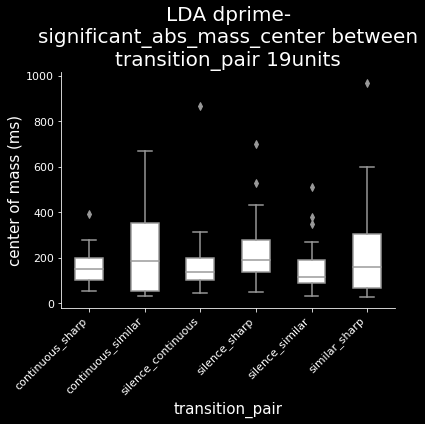

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

continuous_similar v.s. silence_continuous: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.774e-03 stat=4.600e+01
continuous_similar v.s. silence_sharp: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.131e-03 stat=4.100e+01
continuous_similar v.s. silence_similar: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.309e-03 stat=4.900e+01


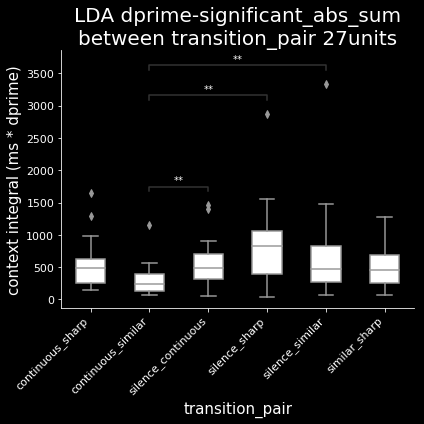

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0d34deb8>)

In [20]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='LDA',
                             nan2zero=False,nozero=True, use_id_probe=True)

condition_effect_on_parameter(parameter='significant_abs_sum', compare='transition_pair', analysis='LDA',
                             nan2zero=False,nozero=True, use_id_probe=True)

# effect of region on metrics

there is no systematic difference between regions, even when using id_probes instead of id

### overview summary plot

In [21]:
def region_metric_comparison(analyses, parameters, y_labels=None, use_id_probes=False, nozeros=True, ax=None):
    # analyses = ('dPCA', )
    # parameters = ('significant_abs_sum', )
    # y_labels=None
    # use_id_probes=False
    # nozeros=True

    ff_parameter = DF.parameter.isin(parameters)
    ff_analysis = DF.analysis.isin(analyses)
    ff_source = DF.source == 'dprime'

    if use_id_probes is True:
        ff_probe = DF.probe != 'mean'
    elif use_id_probes is False:
        ff_probe = DF.probe == 'mean'
    else:
        raise ValueError('use_id_probe must be boolean')

    ff_transpair= DF.transition_pair == 'mean'
    ff_good = DF.value > 0  # empirical good value to filter out garbage cells

    filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good,
                      ['region', 'id_probe', 'analysis', 'parameter', 'value']]
    if nozeros is True:
        filtered = filtered.loc[filtered.value>0,: ]
    elif nozeros is False:
        pass
    else:
        raise ValueError('nozeros must be bool')

    if len(parameters)>1 or len(analyses)>1:
        g = sns.catplot(x='region', y='value', row='parameter', col='analysis',
                        data=filtered, kind='swarm', dodge=True, sharex=False)
        fig = g.fig
        axes = g.axes
        for row, col in np.ndindex(axes.shape):
            ax = axes[row,col]
            if row == 0:
                ax.set_title(analyses[col])
            else:
                ax.set_title(None)

            if col ==0:
                if y_labels is None:
                    ax.set_ylabel(parameters[row])
                else:
                    ax.set_ylabel(y_labels[parameters[row]])
            else:
                pass
    else:
        if ax is None:
            fig, ax = plt.subplots()

        ax = sns.boxplot(x='region', y='value', data=filtered, ax=ax)
        fig = ax.get_figure()
        # ax = sns.swarmplot(x='region', y='value', data=filtered, ax=ax, dodge=True)

        # no significant comparisons
        box_pairs = [("A1", "PEG")]
        stat_resutls = fplt.add_stat_annotation(ax, data=filtered, x='region', y='value', test='Mann-Whitney',
                                           box_pairs=box_pairs, width=0.5, comparisons_correction='bonferroni')

        ax.set_title(f'{analysis} n={filtered.shape[0]}')
        if y_labels is None:
            ax.set_ylabel(parameters[0])
        else:
            ax.set_ylabel(y_labels[parameters[[0]]])
        axes = ax

    return fig, axes

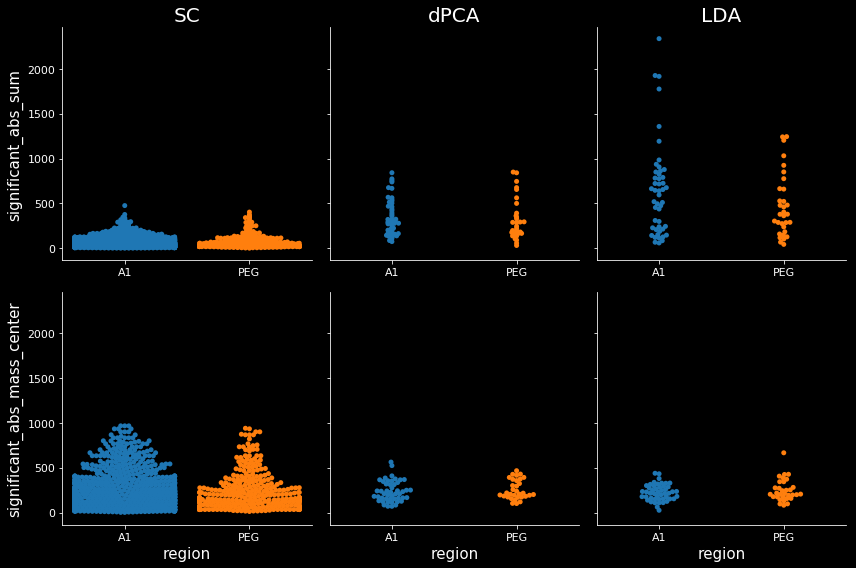

In [22]:
parameters = ['significant_abs_sum', 'significant_abs_mass_center']
analyses = ['SC', 'dPCA', 'LDA']

fig, axes = region_metric_comparison(analyses, parameters, use_id_probes=True, nozeros=True)
fig.set_size_inches([12,8])
fig.tight_layout()

### each subplot with significance tests

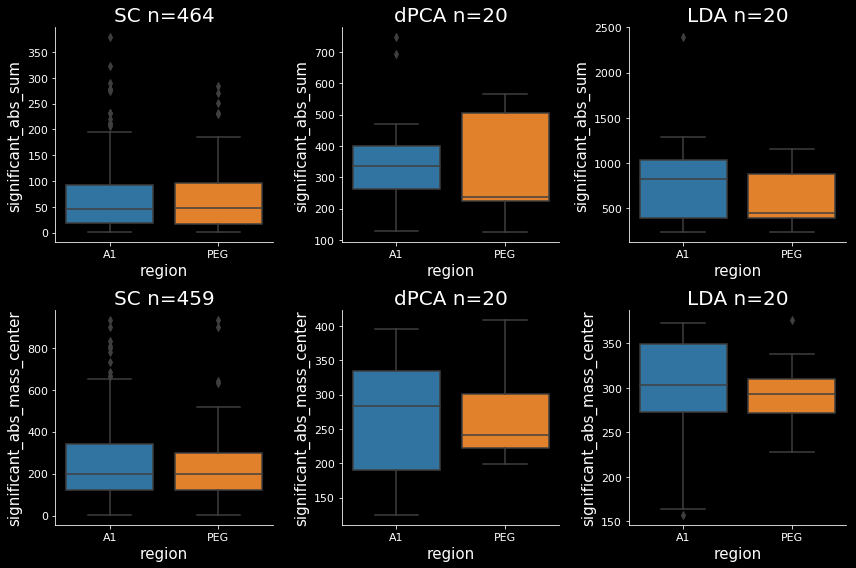

In [23]:
fig, axes = plt.subplots(len(parameters),len(analyses))
for (col, analysis), (row, parameter) in itt.product(enumerate(analyses), enumerate(parameters)):
    region_metric_comparison((analysis,), (parameter,), use_id_probes=False, nozeros=True, ax=axes[row,col])
fig.set_size_inches([12, 8])
fig.tight_layout()


## population and singe unit comparison

In [24]:
def pop_SC_param_comparison(parameter, pop_analysis='pdPCA', nan2zero=False, nozero=True,
                            id_probe=False, color_regions=False):
    # parameter = 'significant_abs_sum'
    # pop_analysis = 'pdPCA'
    # color_regions = True
    # nan2zero=False
    # nozero=True
    # id_probe=True

    if nan2zero:
        cleaned = DF.fillna(value={'value':0})
    elif nan2zero is False:
        cleaned = DF.dropna(axis=0, subset=['value'])
    else:
        raise ValueError('nan2zero not bool')


    # set common filters for single cell and population analysis
    if id_probe:
        ff_probe = cleaned.probe != 'mean'
    else:
        ff_probe = cleaned.probe == 'mean'
    ff_trans = cleaned.transition_pair == 'mean'


    ff_param = cleaned.parameter == parameter
    ff_source = cleaned.source == 'dprime'

    if nozero:
        ff_value = cleaned.value > 0
    elif nozero is False:
        ff_value = cleaned.value >= 0
    else:
        raise ValueError('nozero not bool')

    # Pulls single cell data
    ff_anal = cleaned.analysis == 'SC'
    sing = cleaned.loc[ff_anal & ff_probe & ff_trans & ff_param & ff_source & ff_value,
                  ['siteid', 'cellid', 'region', 'value']]

    sing['site_probe'] =  DF[['siteid', 'probe']].agg('_'.join, axis=1)
    sing_pivot = sing.pivot(index='site_probe', columns='cellid', values='value')
    sing_pivot['agg'] = sing_pivot.max(axis=1)


    # Pulls population data
    ff_anal = DF.analysis == pop_analysis
    pops = DF.loc[ff_anal & ff_probe & ff_trans & ff_param & ff_source & ff_value,
                  ['id_probe', 'region', 'value']]

    pops['site_probe'] = DF['id_probe']
    pops = pops.set_index('site_probe')

    toplot = pd.concat((pops.loc[:, ['region', 'value']], sing_pivot.loc[:, 'agg']), axis=1)

    if color_regions is True:
        g = sns.lmplot(x='value', y='agg', hue='region', data=toplot)
        ax = g.ax
    elif color_regions is False:
        ax = sns.regplot(x='value', y='agg', data=toplot, color='white')
    else:
        raise  ValueError('color_regions must be bool')

    _, _, r2, _, _ = sst.linregress(toplot['value'], toplot['agg'])
    _ = fplt.unit_line(ax, square_shape=False)

    ax.set_xlabel(f'population {parameter}')
    ax.set_ylabel(f'single cell {parameter} max')

    fig = ax.figure
    title = f'SC vs {pop_analysis} {parameter} comparison r={r2:.2f}'
    ax.set_title(fill(title, 35))
    plt.show()

    return fig,ax

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



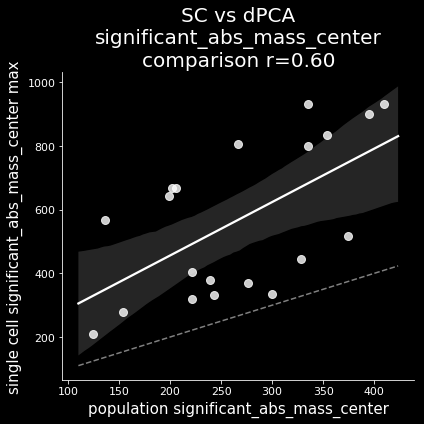

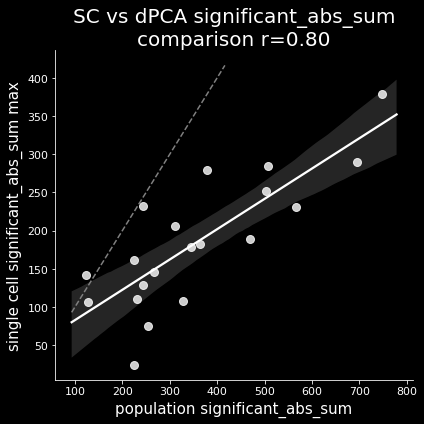

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0c111080>)

In [25]:
# SC vs dPCA center of mass
pop_SC_param_comparison('significant_abs_mass_center', pop_analysis='dPCA', nan2zero=False, nozero=True, id_probe=False)

# SC vs dPCA integral
pop_SC_param_comparison('significant_abs_sum', pop_analysis='dPCA', nan2zero=False, nozero=True, id_probe=False)

In [26]:
# interact(pop_SC_param_comparison, parameter=['significant_abs_mass_center', 'significant_abs_sum'],
#          pop_analysis=['dPCA', 'LDA'], nan2zero=False, nozero=True, id_probe=False, color_region=False)